This notebook is to run some visualizations techniques on the first final model, which performed slightly better than the second model. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, CNN_3d, layer0_12x12, layer2_12x12, layer0_3x6, count_parameters, rnn_2dCNN
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=1000)

In [3]:
"""
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
"""
device = torch.device('cpu')
dtype = torch.float32
print(device)

cpu


In [4]:
import tqdm 

def compute_saliency_maps(m, loader):
    """
    Compute a class saliency map using the model for showers in the DataLoader.
    Input:
    - loader: 
    - m: A pretrained model that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the inp
    ut
    images.
    """
    # Make sure the model is in "test" mode
    m.eval()
    
    
    l0_saliencies = []
    l1_saliencies = []
    l2_saliencies = []
    y_test = []
    
    x0 = []
    x1 = []
    x2 = []
    preds = []

    
    for l0, l1, l2, y in tqdm.tqdm(loader):
        
        l0 = l0.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        l1 = l1.to(device=device, dtype=dtype)
        l2 = l2.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        
        l0.requires_grad_()
        l1.requires_grad_()
        l2.requires_grad_()
        
        # forward pass through the model
        scores = m(l0,l1,l2)
        loss = F.cross_entropy(scores, y)
    
        # backward pass: compute the gradients
        loss.backward()
        
        dl0 = l0.grad
        dl1 = l1.grad
        dl2 = l2.grad
    
        l0_saliencies.append(torch.max(torch.abs(dl0),dim=1)[0])
        l1_saliencies.append(torch.max(torch.abs(dl1),dim=1)[0])
        l2_saliencies.append(torch.max(torch.abs(dl2),dim=1)[0])
        y_test.append(y.cpu().numpy())
    
        x0.append(l0.detach().numpy().squeeze())
        x1.append(l1.detach().numpy().squeeze())
        x2.append(l2.detach().numpy().squeeze())
    
        preds.append(np.argmax(scores.detach().numpy(), axis=1))
    

    # Aggregate the info, and return np arrays for plotting purposes :)
    l0_saliencies = np.concatenate(tuple(l0_saliencies),axis=0)
    l1_saliencies = np.concatenate(tuple(l1_saliencies),axis=0)
    l2_saliencies = np.concatenate(tuple(l2_saliencies),axis=0)
    y_test = np.concatenate(tuple(y_test),axis=0)
    x0 = np.concatenate(tuple(x0),axis=0)
    x1 = np.concatenate(tuple(x1),axis=0)
    x2 = np.concatenate(tuple(x2),axis=0)
    preds = np.concatenate(tuple(preds),axis=0)
        
    return l0_saliencies, l1_saliencies, l2_saliencies, y_test, x0, x1, x2, preds

In [5]:
layer0_params = [32, 3, 3, 1, 1]
layer0_reduce = [1, 3, 93, 1, 1] # ---> Downsampling with one filter at the end

layer1_params = [32, 3, 3, 1, 1]
layer1_reduce = [1, 12, 9, 1, 1] # ---> Downsampling with one filter 

layer2_params = [32, 3, 3, 1, 1]
layer2_reduce = [1, 12, 3, 1, 1] # ---> downsampling with one filter 

rnn_params = [18, 18, 1]

layer3_params = [32, 3, 3, 1, 1]

fc_params = [18, 150, 100, 50, 3, 0.5]

In [6]:
final_one = rnn_2dCNN(layer0_params, layer0_reduce, layer1_params, layer1_reduce, layer2_params, layer2_reduce, rnn_params, layer3_params, fc_params)

final_one.load_state_dict(torch.load("../models/advTraining_1_2.pth.tar"))

Let's produce some saliency maps on the first final model and the test set.

In [7]:
l0_sal, l1_sal, l2_sal, y, x0, x1, x2, preds = compute_saliency_maps(final_one, loader_test)

100%|██████████| 90/90 [04:28<00:00,  2.99s/it]


In [8]:
import matplotlib.pyplot as plt

def show_saliency_maps(l0_map, l1_map, l2_map, x0_img, x1_img, x2_img, title=''):
    '''
    Compare the calorimeter image and saliency map for each layer for a shower.
    
    Inputs:
    - l0_map: saliency map for layer 0
    - l1_map:   "       "   "    "   1
    - l2_map:   "       "   "    "   2
    - x0: calorimeter image in layer 0
    - x1:       "       "   "   "    1
    - x2:       "       "   "   "    2
    - title: The title for the plot!
    '''
    
    # Step 1: Add the mean back to the img (I'll put this in later)
    
    fig = plt.figure(figsize=(6,9))
        
    # Step 3: Loop through the layers and make plots
    for i, x, l in zip(range(3), [x0_img, x1_img, x2_img], [l0_map, l1_map, l2_map]):
                
        # Validation image
        plt.subplot(3,2,i*2+1)
        plt.imshow(x, aspect='auto')
        # Turn off the axis labels
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.ylabel('Layer {}\n$\phi$'.format(i),fontsize=12)
        if i == 0:
            plt.title('Calorimeter Images')
        if i == 2:
            plt.xlabel('$\eta$',fontsize=12)
    
        # Saliency plot
        plt.subplot(3,2,i*2+2)
        plt.imshow(l, cmap=plt.cm.hot, aspect='auto')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if i == 0:
            plt.title('Saliency Maps')
        if i == 2:
            plt.xlabel('$\eta$',fontsize=12)
   
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.925)
    plt.show()

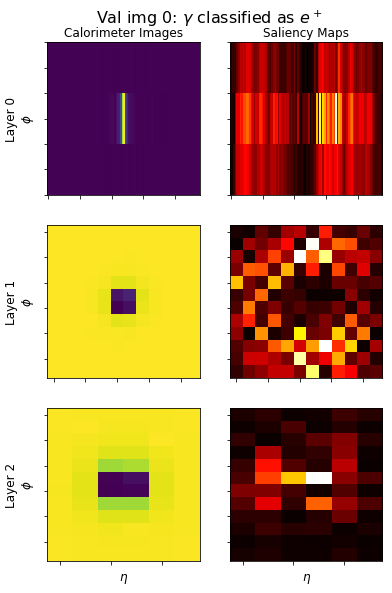

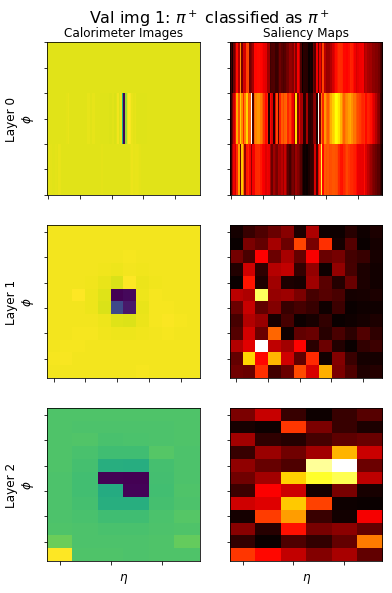

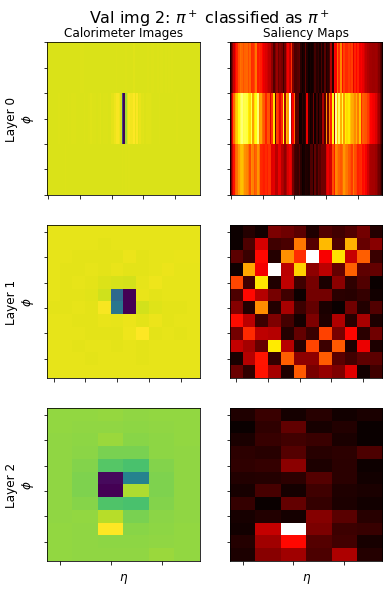

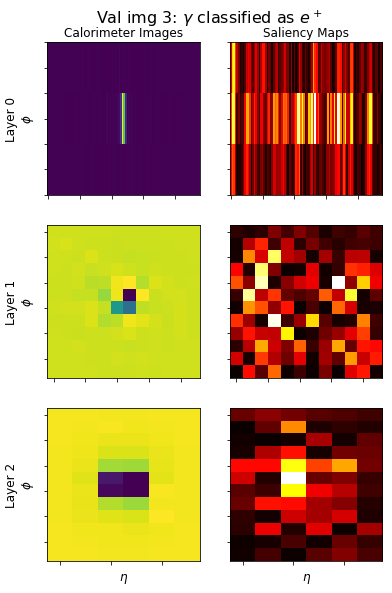

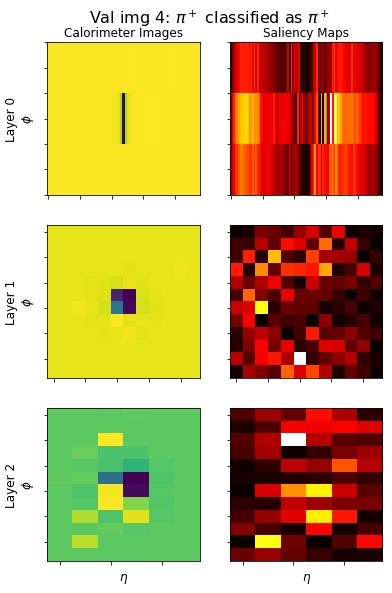

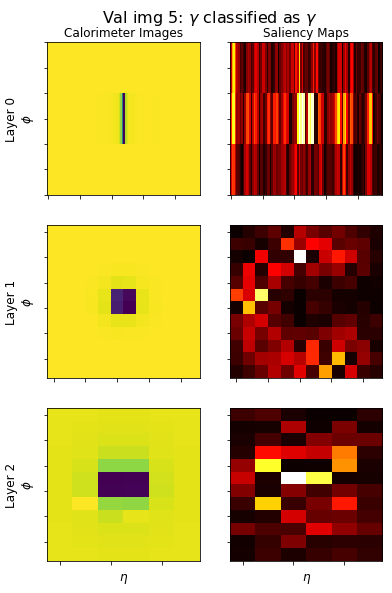

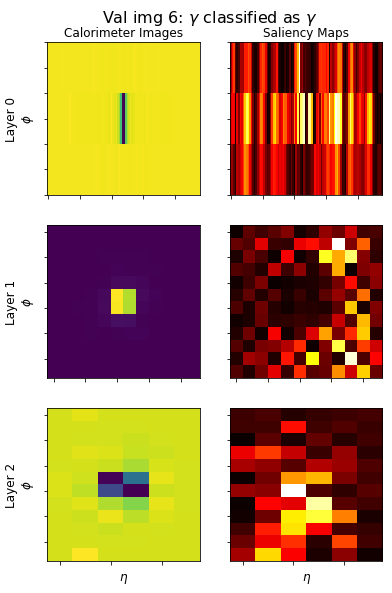

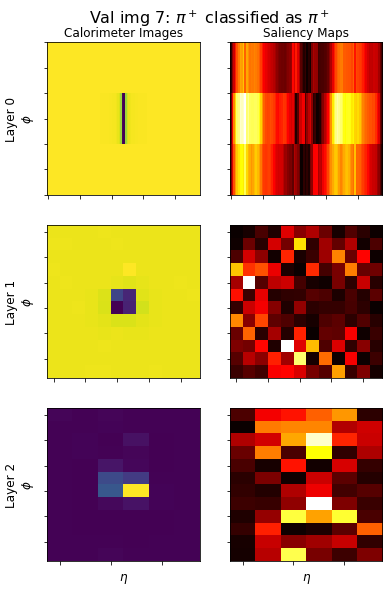

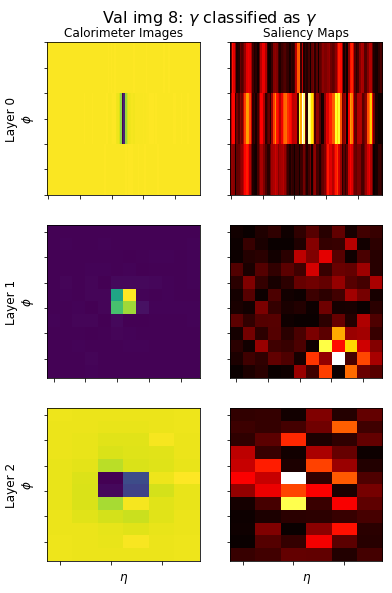

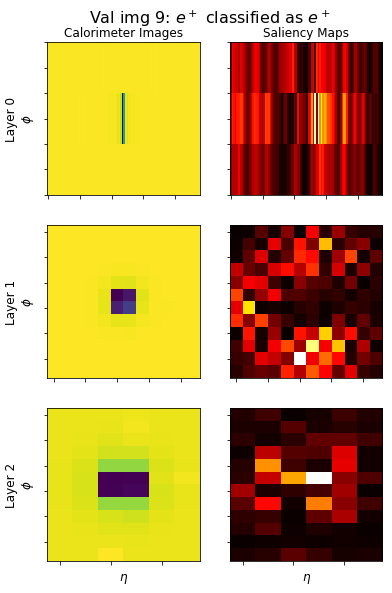

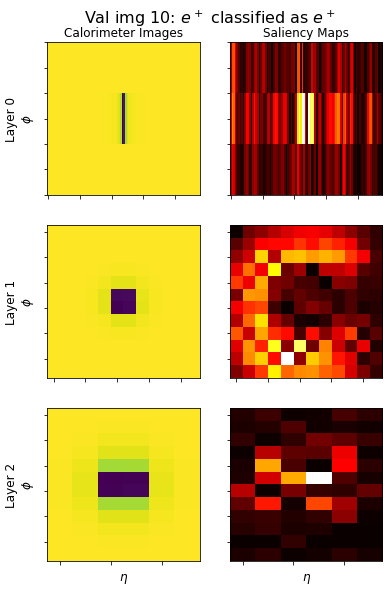

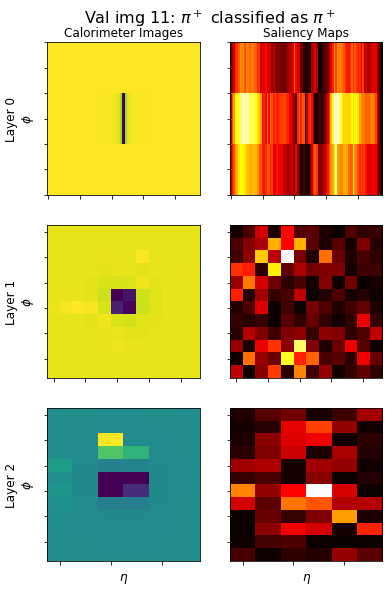

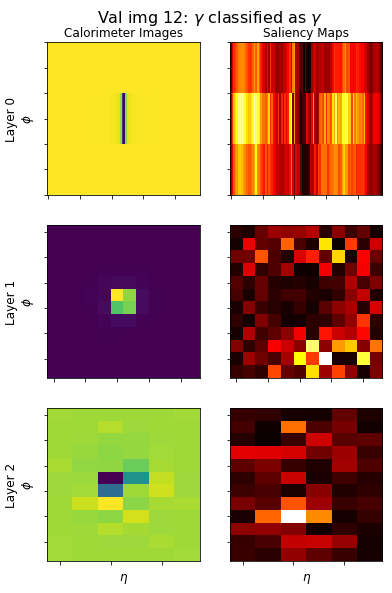

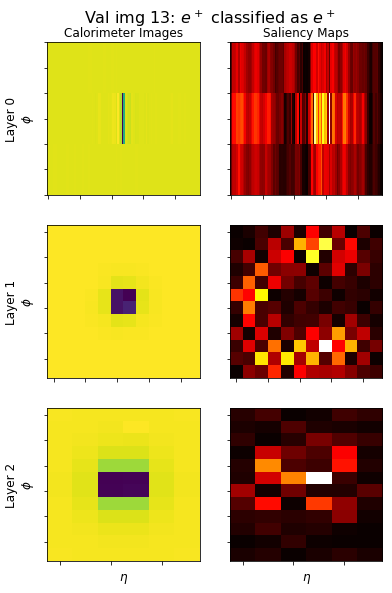

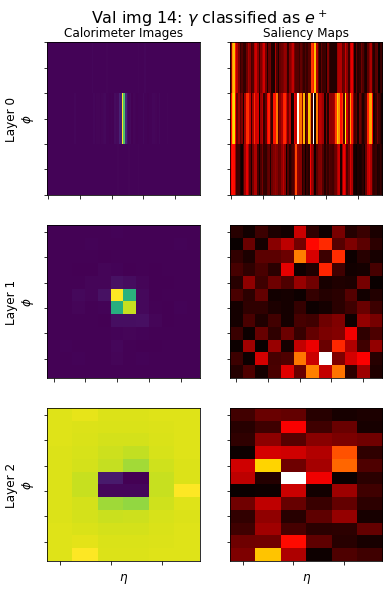

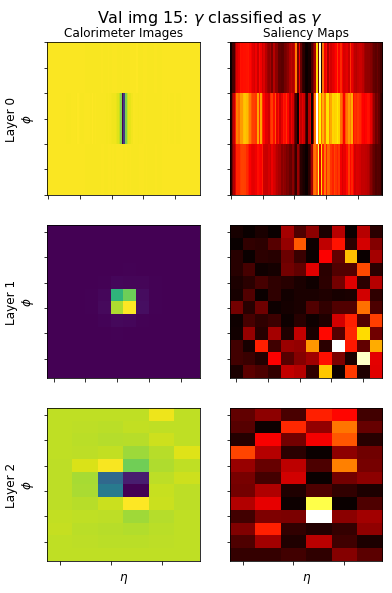

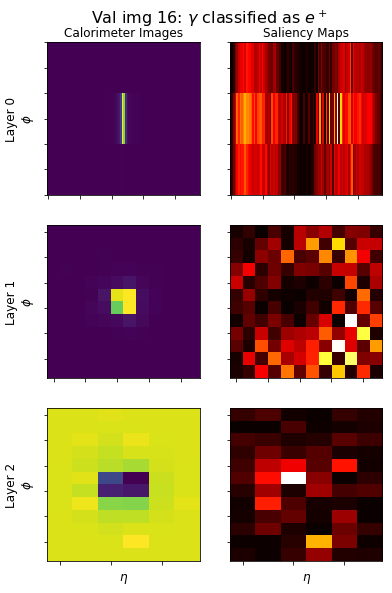

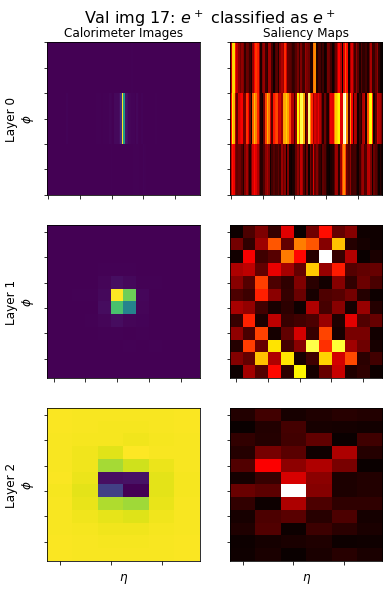

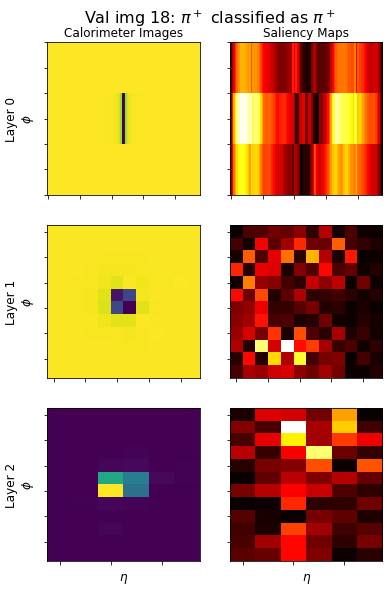

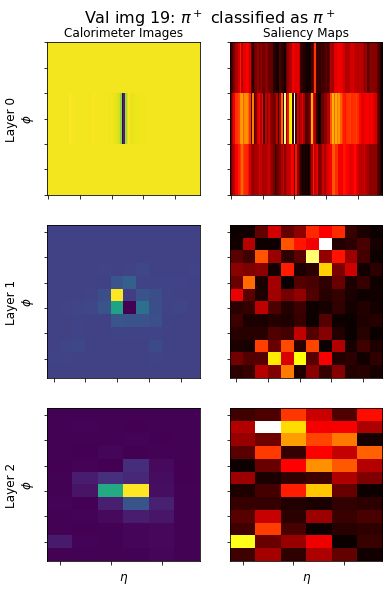

In [10]:
for i in range(20):
    pcle = { 0 : '$\gamma$', 
             1 : '$\pi^+$',
             2 : '$e^+$'}
    title = "Val img {}: {} classified as {}\n".format(i, pcle[y[i]], pcle[preds[i]])
    show_saliency_maps(l0_sal[i], l1_sal[i], l2_sal[i], x0[i], x1[i], x2[i], title)